 # 미래에셋대우 공모 ELS 26005회 조기상환형 조건충족시 연 5%(세전) / 최대손실률 -100%

# HSECI - EUROSTOXX50

 # ELS Pricing

In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#############################setting########################
name = 'EuroStoxx50','HSCEI'
Xmax, Xmin = 8000,0
Ymax,Ymin = 30000,0
mux,muy = 0.056,0.07
sigx,sigy = 0.168,0.306
r = 0.02
Divx, Divy = 0.035,0.025
X,Y =  3446 , 12166
T = 3
pp = 125   # 6개월 = 125day
N = 300
F = 100
cr = np.array([0.025,0.05,0.075,0.1,0.125,0.15]).astype(np.float32)
K = np.array([0.9,0.9,0.9,0.85,0.85,0.8]).astype(np.float32)
KI = 0.5
rho = 0.316
path = r'C:\Users\LIMDAESUN\Desktop\카이스트관련\numerical\가격데이터.xlsx'
path2 = r'C:\Users\LIMDAESUN\Desktop\카이스트관련\numerical\EURO STOXX FUTURES.xlsx'
path3 = r'C:\Users\LIMDAESUN\Desktop\카이스트관련\numerical\HSCEI FUTURES.xlsx'
Mozip_Gaek = 15000000000 # 모집가액 15000000 * 1천원
eating_BP = 0.01
###########################################################
M = len(cr)*pp
dx = (Xmax-Xmin)/N
dy = (Ymax-Ymin)/N

def my_node(Y,X) :
    global dx, dy
    return int(np.float32(Y/dy)), int(np.float32(X/dx))

y,x = my_node(Y,X)

def make_variable(X= X,dx=dx,Y=Y,dy=dy,Xmax=Xmax,Ymax=Ymax) :
    Kx_ = (X*K/dx + 0.4999).astype(np.int32)
    Ky_ = (Y*K/dy + 0.4999).astype(np.int32)
    KIx_num = int(X*KI/dx + 0.4999)
    KIy_num = int(Y*KI/dy + 0.4999)
    Xrange,Yrange = np.arange(0,Xmax+1,dx),np.arange(0,Ymax+1,dy)
    KI_conditionX = (Xrange<X * KI).sum()
    KI_conditionY = (Yrange<Y * KI).sum()
    K0_conditionX = (Xrange< K[-1] * X).sum()
    K0_conditionY = (Yrange< K[-1] * Y).sum()
    return Kx_, Ky_, KIx_num, KIy_num, Xrange, Yrange, KI_conditionX, KI_conditionY, K0_conditionX, K0_conditionY

Kx_, Ky_, KIx_num, KIy_num, Xrange, Yrange, KI_conditionX, KI_conditionY, K0_conditionX, K0_conditionY = make_variable(X= X,dx=dx,Y=Y,dy=dy,Xmax=Xmax,Ymax=Ymax) 


def ELS_pricing(Xmax, Xmin, Ymax, Ymin, mux, muy, sigx, sigy, r, Divx, Divy, X, Y, T,N,F,cr, K, KI, rho,pp=pp) :
    global dx, dy, Kx_, Ky_, KIx_num, KIy_num, Xrange, Yrange, KI_conditionX, KI_conditionY, K0_conditionX, K0_conditionY 
    inv = np.linalg.inv
    CR = cr[::-1]
    #con1 = np.float32(abs(X/dx - int(X/dx))) in [0,1]
    #con2 = np.float32(abs(Y/dy - int(Y/dy))) in [0,1]

    dt = T/M
    nx = np.arange(1,N)
    ny = np.arange(1,N)
    h = dt

    ####################################################################################
    an = 1+ h * (0.5*(r) + (r-Divy)*ny + (sigy*ny)**2)
    bn = -(sigy*ny)**2*0.5*h
    cn = -(sigy*ny)**2*0.5*h - (r-Divy)*ny*h

    an[0] = an[0] + 2*bn[0]
    an[-1] = an[-1] + 2*cn[-1]

    cn[0] = cn[0]-bn[0]
    bn[-1] = bn[-1] - cn[-1]

    al = 1 + h * (0.5*(r) + (r-Divx)*nx + (sigx * nx) **2)
    bl = -(sigx*nx)**2*0.5*h
    cl = -(sigx*nx)**2*0.5*h - (r-Divx)*nx*h

    al[0] = al[0] + 2*bl[0]
    al[-1] = al[-1] + 2*cl[-1]

    cl[0] = cl[0]-bl[0]
    bl[-1] = bl[-1] - cl[-1]


    an = an.astype(np.float32)
    bn = bn.astype(np.float32)
    cn = cn.astype(np.float32)
    al = al.astype(np.float32)
    bl = bl.astype(np.float32)
    cl = cl.astype(np.float32)
    #########################################################################################
    k = np.array([bn[1:], an, cn[:-1]])
    k2 = np.array([bl[1:], al, cl[:-1]])
    offset = [-1,0,1]
    diag = diags(k,offset).toarray()
    diag2 = diags(k2,offset).toarray()
    A = inv(diag)
    B = inv(diag2)
    A,B = A.astype(np.float32), B.astype(np.float32)

    number_x, number_y = int(Xmax/dx), int(Ymax/dy)
    Data = np.zeros((M,number_x+1,number_y+1), dtype=np.float32) # x = 0~1000, y = 0~1000
    Data_hat = Data.copy()

    AAA = rho * sigy * sigx * h / 8 
    nl = ny.reshape(len(ny),1).dot(nx.reshape(1,len(nx))).astype(np.int32)
    nl2 = nx.reshape(len(nx),1).dot(ny.reshape(1,len(ny))).astype(np.int32)
    
    
    def make_KI_data(Data,Data_hat):

        
        #conditionY = (Yrange<KIy).sum() # 넉인 아래의 Y축 갯수
        #conditionX = (Xrange<KIx).sum() # 넉인 아래의 X축 갯수
        Data[0][:, :K0_conditionX] = 0 
        Data[0][:K0_conditionY, :] = 0

        for i in range(len(Xrange[:K0_conditionX])) :
            for j in range(len(Yrange)) :
                Data[0][j,i] = min(F*Yrange[j]/Y,F*Xrange[i]/X)
        for i in range(len(Yrange[:K0_conditionY])) :
            for j in range(len(Xrange)) :
                Data[0][i,j] = min(F*Yrange[i]/Y,F*Xrange[j]/X)
        Data[0][K0_conditionY:, K0_conditionX:] =  F * (1+CR[0])
        for t in range(M-1) :
            d = Data[t][1:-1,1:-1] + AAA * nl * (Data[t][2:,2:]+Data[t][:-2,:-2]-
                                            Data[t][:-2,2:]-
                                            Data[t][2:,:-2])
            Data_hat[t][1:-1,1:-1] = A.dot(d)
            Data_hat[t][:,0] = 2* Data_hat[t][:,1] - Data_hat[t][:,2]
            Data_hat[t][0,:] = 2* Data_hat[t][1,:] - Data_hat[t][2,:]
            Data_hat[t][-1,:] = 2*Data_hat[t][-2,:] -Data_hat[t][-3,:]
            Data_hat[t][:,-1] = 2*Data_hat[t][:,-2] -Data_hat[t][:,-3]
            Data_hat_T = Data_hat[t].T

            d = Data_hat_T[1:-1,1:-1] + AAA * nl2 * (Data_hat_T[2:,2:]+Data_hat_T[:-2,:-2]-
                                            Data_hat_T[:-2,2:]-
                                            Data_hat_T[2:,:-2])
            temp = B.dot(d)
            Data[t+1][1:-1,1:-1] = temp.T
            Data[t+1][:,0] =  2* Data[t+1][:,1] - Data[t+1][:,2]
            Data[t+1][0,:] = 2* Data[t+1][1,:] - Data[t+1][2,:]
            Data[t+1][-1,:] = 2*Data[t+1][-2,:] -Data[t+1][-3,:]
            Data[t+1][:,-1] = 2*Data[t+1][:,-2] -Data[t+1][:,-3] 

            if (t+2)%pp == 0 and t<=(len(CR)-1)*pp :
                Kx,Ky = X *K[-(int((t+2)/pp))-1] , Y * K[-(int((t+2)/pp))-1]
                conditionY = (Yrange<Ky).sum() # 행사가격 아래의 Y축 갯수
                conditionX = (Xrange<Kx).sum() # 행사가격 아래의 X축 갯수
                Data[t+1][conditionY:,conditionX:] = F * (1+CR[int((t+2)/pp)])   
        return Data
    KI_Data = make_KI_data(Data,Data_hat).copy()
    def make_NKI_data(Data,Data_hat,KI_Data):

        
        #conditionY = (Yrange<KIy).sum() # 넉인 아래의 Y축 갯수
        #conditionX = (Xrange<KIx).sum() # 넉인 아래의 X축 갯수
        Data[0][:, :KI_conditionX] = 0 
        Data[0][:KI_conditionY, :] = 0

        for i in range(len(Xrange[:KI_conditionX])) :
            for j in range(len(Yrange)) :
                Data[0][j,i] = min(F*Yrange[j]/Y,F*Xrange[i]/X)
        for i in range(len(Yrange[:KI_conditionY])) :
            for j in range(len(Xrange)) :
                Data[0][i,j] = min(F*Yrange[i]/Y,F*Xrange[j]/X)
        Data[0][KI_conditionY:, KI_conditionX:] =  F * (1+CR[0])
        for t in range(M-1) :
            d = Data[t][1:-1,1:-1] + AAA * nl * (Data[t][2:,2:]+Data[t][:-2,:-2]-
                                            Data[t][:-2,2:]-
                                            Data[t][2:,:-2])
            Data_hat[t][1:-1,1:-1] = A.dot(d)
            Data_hat[t][:,0] = 2* Data_hat[t][:,1] - Data_hat[t][:,2]
            Data_hat[t][0,:] = 2* Data_hat[t][1,:] - Data_hat[t][2,:]
            Data_hat[t][-1,:] = 2*Data_hat[t][-2,:] -Data_hat[t][-3,:]
            Data_hat[t][:,-1] = 2*Data_hat[t][:,-2] -Data_hat[t][:,-3]
            Data_hat_T = Data_hat[t].T

            d = Data_hat_T[1:-1,1:-1] + AAA * nl2 * (Data_hat_T[2:,2:]+Data_hat_T[:-2,:-2]-
                                            Data_hat_T[:-2,2:]-
                                            Data_hat_T[2:,:-2])
            temp = B.dot(d)
            Data[t+1][1:-1,1:-1] = temp.T
            Data[t+1][:,0] =  2* Data[t+1][:,1] - Data[t+1][:,2]
            Data[t+1][0,:] = 2* Data[t+1][1,:] - Data[t+1][2,:]
            Data[t+1][-1,:] = 2*Data[t+1][-2,:] -Data[t+1][-3,:]
            Data[t+1][:,-1] = 2*Data[t+1][:,-2] -Data[t+1][:,-3] 

            if (t+2)%pp == 0 and t<=(len(CR)-1)*pp :
                Kx,Ky = X *K[-(int((t+2)/pp))-1] , Y * K[-(int((t+2)/pp))-1]
                conditionY = (Yrange<Ky).sum() # 행사가격 아래의 Y축 갯수
                conditionX = (Xrange<Kx).sum() # 행사가격 아래의 X축 갯수
                Data[t+1][conditionY:,conditionX:] = F * (1+CR[int((t+2)/pp)])
            Data[t+1][:KI_conditionY,:] = KI_Data[t+1][:KI_conditionY,:]
            Data[t+1][:,:KI_conditionX] = KI_Data[t+1][:,:KI_conditionX]
        return Data
    
    NKI_Data = make_NKI_data(Data,Data_hat,KI_Data)

    return NKI_Data

In [2]:

def make_vega(ELS_3d_matrix) :
    global dx, dy
    Price = ELS_3d_matrix
    New_Price_Vx = ELS_pricing(Xmax, Xmin, Ymax, Ymin, mux, muy, sigx+sigx*0.01, sigy, r, Divx, Divy, X, Y, T,N,F,cr, K, KI, rho)
    New_Price_Vy = ELS_pricing(Xmax, Xmin, Ymax, Ymin, mux, muy, sigx, sigy+sigy*0.01, r, Divx, Divy, X, Y, T,N,F,cr, K, KI, rho)
    VegaX = (New_Price_Vx - Price)
    VegaY = (New_Price_Vy - Price)

    return VegaX ,VegaY

def sensitive_rho(ELS_3d_matrix) :
    global dx, dy
    Price = ELS_3d_matrix
    New_Price_rho = ELS_pricing(Xmax, Xmin, Ymax, Ymin, mux, muy, sigx, sigy, r, Divx, Divy, X, Y, T,N,F,cr, K, KI, rho+0.01*rho)[M-1]
    return New_Price_rho - Price
    
def ELS_Factor(ELS_3d_matrix) :
    global dx, dy
    Price = ELS_3d_matrix
    DeltaY = Price*0
    DeltaY[:,:-1,:] = ((Price[:,1:,:] - Price[:,:-1,:]))/F/(dy/Y)
    DeltaY[:,-1,:] = 2*DeltaY[:,-2,:] - DeltaY[:,-3,:]

    DeltaX = Price*0
    DeltaX[:,:,:-1] = ((Price[:,:,1:] - Price[:,:,:-1])/F)/(dx/X)
    DeltaX[:,:,-1] = 2*DeltaX[:,:,-2] - DeltaX[:,:,-3]

    GammaX = Price*0
    GammaX[:,:,:-1] = ((DeltaX[:,:,1:] - DeltaX[:,:,:-1])/F)/(dx/X)
    GammaX[:,:,-1] = 2*GammaX[:,:,-2] - GammaX[:,:,-3] 

    GammaY = Price*0
    GammaY[:,:-1,:] = ((DeltaY[:,1:,:] - DeltaY[:,:-1,:])/F)/(dy/Y)
    GammaY[:,-1,:] = 2*GammaY[:,-2,:] - GammaY[:,-3,:]

    GammaXY = Price*0
    GammaXY = ((DeltaY[:,:,1:] - DeltaY[:,:,:-1])/F)/(dx/X)
    GammaXY[:,:,-1] = 2*GammaXY[:,:,-2] - GammaXY[:,:,-3]                        

    return DeltaX, DeltaY, GammaX, GammaY, GammaXY

def Monte(X,Y,sigx,sigy,rho,r,cr,K,KI,number_of_simul = 20000) :
    DF = np.exp(-np.arange(T/len(cr),T+T/len(cr),T/len(cr))*r).astype(np.float32)
    KIx, KIy = KI * X , KI * Y
    
    cov = [[1,rho],[rho,1]]
    Time_number = M
    t = T/Time_number
    Time_space = np.linspace(0,T,Time_number+1).astype(np.float32)
    
    multinorm = np.random.multivariate_normal([0,0], cov, Time_number * number_of_simul).astype(np.float32)
    
    eex,eey = multinorm[:,0],multinorm[:,1].astype(np.float32)
    
    ex = np.r_[np.zeros((1,number_of_simul)), eex.reshape(Time_number,number_of_simul)]
    ey = np.r_[np.zeros((1,number_of_simul)), eey.reshape(Time_number,number_of_simul)]
    
    cumul_ex = ex.cumsum(axis = 0)
    cumul_ey = ey.cumsum(axis = 0)
    
    Time_space = Time_space.reshape(Time_number+1,1)
    price1 = X*np.exp( (r-Divx-0.5*sigx**2)*Time_space + sigx*np.sqrt(t)*cumul_ex)
    price2 = Y*np.exp( (r-Divy-0.5*sigy**2)*Time_space + sigy*np.sqrt(t)*cumul_ey)
    KI_x_array = ((price1<KIx).sum(0)>0) * 1
    KI_y_array = ((price2<KIy).sum(0)>0) * 1
    KI_num = ((((price1<KIx).sum(0) > 0) * 1 + ((price2<KIy).sum(0) > 0) * 1)>0) * 1
    Autocall_Value = (F * (1 + cr) * DF).reshape(len(cr),1)
    
    ##넉인 케이스
    KI_casex = (price1 * KI_num)[pp::pp]
    KI_casey = (price2 * KI_num)[pp::pp]
    ## 넉인 + 조기행사 조건
    KI_Kcons_x = np.array([list(K*X)]*number_of_simul).astype(np.float32).T * KI_num
    KI_Kcons_y = np.array([list(K*Y)]*number_of_simul).astype(np.float32).T * KI_num    
    
    Autocall_KI_case_x = KI_casex>KI_Kcons_x
    Autocall_KI_case_y = KI_casey>KI_Kcons_y
    Autocall_KI_case = Autocall_KI_case_x * Autocall_KI_case_y
    When_Autocall_KI_case = (Autocall_KI_case.cumsum(0) == 1)* Autocall_KI_case
    KI_Autocall_total_value = (When_Autocall_KI_case  * Autocall_Value).sum(0).sum() # 넉인할 때 + Autocall 할 때의 Value 총합
    #넉인 + Not Autocall
    KI_but_not_Autocall = KI_num - When_Autocall_KI_case.sum(0)
    
    KI_but_not_Autocall_lastx = F * KI_casex[-1] * KI_but_not_Autocall/X
    KI_but_not_Autocall_lasty = F * KI_casey[-1] * KI_but_not_Autocall/Y    
    KI_but_not_Autocall_total_value = (DF[-1]*np.concatenate([KI_but_not_Autocall_lastx.reshape(1,number_of_simul),KI_but_not_Autocall_lasty.reshape(1,number_of_simul)],axis = 0).min(0)).sum()
    
    #Not 넉인 케이스
    NKI_num = 1 - KI_num
    NKI_casex = (price1 * NKI_num)[pp::pp]
    NKI_casey = (price2 * NKI_num)[pp::pp]
    
    ##Not 넉인 조기행사조건
    NKI_Kcons_x = np.array([list(K*X)]*number_of_simul).astype(np.float32).T * NKI_num
    NKI_Kcons_y = np.array([list(K*Y)]*number_of_simul).astype(np.float32).T * NKI_num
    Autocall_NKI_case_x = NKI_casex>NKI_Kcons_x
    Autocall_NKI_case_y = NKI_casey>NKI_Kcons_y
    Autocall_NKI_case = Autocall_NKI_case_x * Autocall_NKI_case_y     
    When_Autocall_NKI_case = (Autocall_NKI_case.cumsum(0) == 1)* Autocall_NKI_case
    NKI_Autocall_total_value = (When_Autocall_NKI_case  * Autocall_Value).sum(0).sum()
    
    ##Not 넉인조기행사 안되는조건
    NKI_but_not_Autocall = NKI_num - When_Autocall_NKI_case.sum(0)
    NKI_but_not_Autocall_total_value = (NKI_but_not_Autocall * F * (1+cr[-1])*DF[-1]).sum()
    
    return (KI_Autocall_total_value + KI_but_not_Autocall_total_value + NKI_Autocall_total_value + NKI_but_not_Autocall_total_value)/number_of_simul , (KI_num>0).sum()/number_of_simul


In [3]:

Price = ELS_pricing(Xmax, Xmin, Ymax, Ymin, mux, muy, sigx, sigy, r, Divx, Divy, X, Y, T,N,F,cr, K, KI, rho,pp=pp)
Monte_Price, KI_p = Monte(X,Y,sigx,sigy,rho,r,cr,K,KI,number_of_simul = 20000)
DeltaX, DeltaY, GammaX, GammaY, GammaXY = ELS_Factor(Price)
sens_rho = sensitive_rho(Price)
VegaX,VegaY = make_vega(Price)


In [4]:


def Plotting(DeltaY = DeltaY, DeltaX= DeltaX) :
    global N, Ymin, Ymax, x, y, name
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(np.linspace(Ymin,Ymax,N+1), DeltaY[M-1][:,x], color = 'black')
    plt.xlabel(name[1])
    plt.ylabel('Delta of '+name[1])

    plt.subplot(2,1,2)
    plt.xlabel(name[0])
    plt.ylabel('Delta of '+name[0])
    plt.plot(np.linspace(Xmin,Xmax,N+1), DeltaX[M-1][y,:], color = 'blue')
    plt.show()

def fun(Y,X) :
    
    return Price[M-1][Y,X]
vec_fun = np.vectorize(fun)

def Plot_Price() :
    global N,dx,dy,name
    S2=np.arange(0,N,1).astype(np.int32)
    S1=np.arange(0,N,1).astype(np.int32)
    YY,XX = np.meshgrid(S2,S1)
    Z = vec_fun(YY,XX)

    YYY,XXX = np.meshgrid(S2*dy,S1*dx)

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')


    # Plot a 3D surface
    ax.plot_surface(YYY,XXX, Z)
    ax.set_title('Result of OS FDM')
    ax.set_xlabel(name[1])
    ax.set_ylabel(name[0])
    ax.set_zlabel('ELS_Price')
    plt.show()

def Result() :
    Lst = [Price[M-1,y,x],
           KI_p,
           DeltaX[M-1,y,x]*F/Price[M-1,y,x],
          DeltaY[M-1,y,x]*F/Price[M-1,y,x],
          GammaX[M-1,y,x]*F/Price[M-1,y,x],
          GammaY[M-1,y,x]*F/Price[M-1,y,x],
          GammaXY[M-1,y,x]*F/Price[M-1,y,x],
          VegaX[M-1, y,x]*F/Price[M-1,y,x],
          VegaY[M-1,y,x]*F/Price[M-1,y,x],
          sens_rho[M-1][y,x]*F/Price[M-1,y,x]]
    Result = pd.DataFrame(Lst,index=['Price','KI_P','DeltaX','DeltaY','GammaX','GammaY','GammaXY','VegaX','VegaY','sensitive_rho'],columns=['OS']).round(4)
    return Result

def Plotting(DeltaY = DeltaY, DeltaX= DeltaX, M = M) :
    global N, Ymin, Ymax, x, y, name
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(np.linspace(Ymin,Ymax,N+1), DeltaY[M-1][:,x], color = 'black')
    plt.xlabel(name[1])
    plt.ylabel('Delta of '+name[1])

    plt.subplot(2,1,2)
    plt.xlabel(name[0])
    plt.ylabel('Delta of '+name[0])
    plt.plot(np.linspace(Xmin,Xmax,N+1), DeltaX[M-1][y,:], color = 'blue')
    plt.show()

def Plot_Price() :
    global N,dx,dy,name
    S2=np.arange(0,N,1).astype(np.int32)
    S1=np.arange(0,N,1).astype(np.int32)
    YY,XX = np.meshgrid(S2,S1)
    Z = vec_fun(YY,XX)

    YYY,XXX = np.meshgrid(S2*dy,S1*dx)

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')


    # Plot a 3D surface
    ax.plot_surface(YYY,XXX, Z)
    ax.set_title('Result of OS FDM')
    ax.set_xlabel(name[1])
    ax.set_ylabel(name[0])
    ax.set_zlabel('ELS_Price')
    plt.show()

Res = Result()


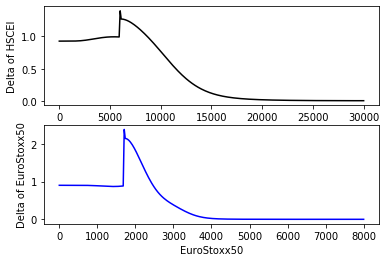

In [5]:
Plotting()

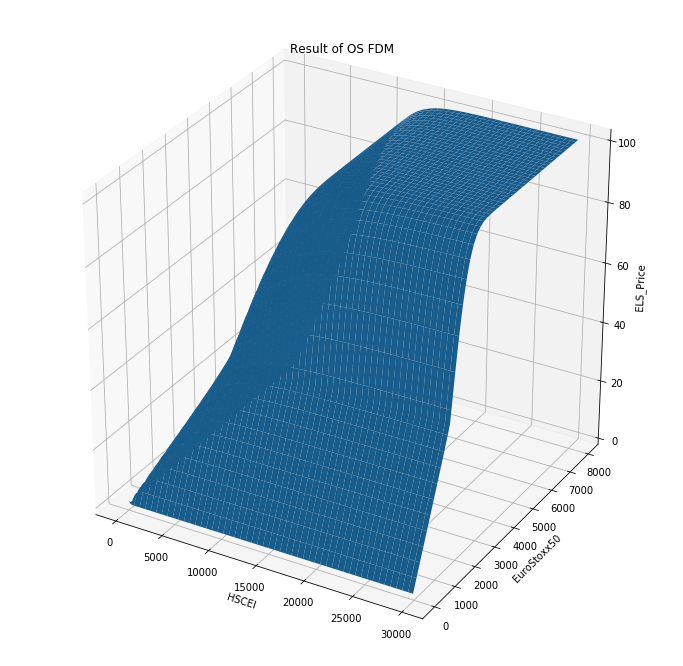

In [6]:
Plot_Price()

In [7]:
Res

,OS
Price,93.0167
KI_P,0.2767
DeltaX,0.1615
DeltaY,0.4316
GammaX,-0.0151
GammaY,-0.0193
GammaXY,0.0013
VegaX,-0.0536
VegaY,-0.2190
sensitive_rho,0.0049


In [8]:
print('몬테카를로 가격 : ',Monte_Price)

몬테카를로 가격 :  93.18803419282058


In [9]:
def my_menu(price_path = path,eurof_path = path2, hscef_path = path3 , Mozip_Gaek = 15000000000, eating_BP = 0.01) :

    Port_Value = Mozip_Gaek * (1-eating_BP) # 100bp먹음
    Profit = Mozip_Gaek - Port_Value # 이득


    num_of_ELS = Port_Value/(float(Res.loc['Price'])) # ELS갯수
    my_price = pd.read_excel(path, index_col=0).astype(np.int16) # 현물 가격데이터
    F1 = pd.read_excel(path2, index_col=0) #STOXX 50 선물
    F2 = pd.read_excel(path3, index_col=0) #HSCEI 선물
    F1.columns = ['EURO F']
    F2.columns = ['HSCE F']
    Futures = pd.concat([F1,F2],axis = 1)  #STOXX 50 선물, HSCEI 선물 데이터 프레임
    my_price.index = pd.to_datetime(my_price.index) 
    yx_num = (np.array(my_price[my_price.columns[::-1]])/np.array([dy,dx])).astype(np.int16) # (모든 EURO STOXX, HSCEI 가격 경로) / dx

    lst = []
    DeltaX_lst = []
    DeltaY_lst = []
    VegaX_lst = []
    VegaY_lst = []
    for n,i in enumerate(yx_num) :
        lst.append(Price[M-1-n][tuple(i)]) # 과거 가격 경로에 따른 ELS가격 다 구하기

        DeltaX_lst.append(  (DeltaX[M-1-n][tuple(i)]*F/Price[M-1-n][tuple(i)])/ Price[M-1-n][tuple(i)] ) #델타는 가격 100기준으로 구했던거를 다시 ELS가격 기준으로 구해서 과거 모든 가격에 대해 델타를 구한다.
        DeltaY_lst.append(  (DeltaY[M-1-n][tuple(i)]*F/Price[M-1-n][tuple(i)])/ Price[M-1-n][tuple(i)] ) 
        VegaX_lst.append(  (VegaX[M-1-n][tuple(i)]*F/Price[M-1-n][tuple(i)])/Price[M-1-n][tuple(i)]  ) # 베가도 마찬가지로 100이아닌 ELS 가격 기준으로 다시 구함
        VegaY_lst.append(  (VegaY[M-1-n][tuple(i)]*F/Price[M-1-n][tuple(i)])/Price[M-1-n][tuple(i)]  )

    lst = np.array(lst)
    DeltaX_lst = np.array(DeltaX_lst)
    DeltaY_lst = np.array(DeltaY_lst)
    VegaX_lst = np.array(VegaX_lst)
    VegaY_lst = np.array(VegaY_lst)

    ELS_Value = (lst * num_of_ELS).astype(np.int64)
    DeltaX_Value = (ELS_Value * DeltaX_lst).astype(np.int64)
    DeltaY_Value = (ELS_Value * DeltaY_lst).astype(np.int64)
    VegaX_Value = (ELS_Value * VegaX_lst).astype(np.int64)
    VegaY_Value = (ELS_Value * VegaY_lst).astype(np.int64)
    
    #ELS 매도 포지션에 대한 데이터
    my_price['ELS_Value'] = -ELS_Value
    my_price['DeltaX'] = -DeltaX_Value
    my_price['DeltaY'] = -DeltaY_Value
    my_price['VegaX'] = -VegaX_Value
    my_price['VegaY'] = -VegaY_Value

    my_price['Cash_DeltaX'] = (my_price['DeltaX'] * lst / my_price['EURO STOXX 50']).astype(np.int64) # %chnge 델타에서 단순 Cash Base 델타로 변환
    my_price['Cash_DeltaY'] = (my_price['DeltaY'] * lst / my_price['홍콩 H']).astype(np.int64) 

    my_price['Cash_VegaX'] = -(lst * VegaX_lst * num_of_ELS * lst / sigx).astype(np.int64) # % chnge 베가에서 단순 Cash Base 베가로 변환
    my_price['Cash_VegaY'] = -(lst * VegaY_lst * num_of_ELS * lst / sigy).astype(np.int64)
    my_price['dDeltaX'] = my_price['Cash_DeltaX'].diff()
    my_price['dDeltaX'].iloc[0] = my_price['Cash_DeltaX'].iloc[0]
    my_price['dDeltaY'] = my_price['Cash_DeltaY'].diff()
    my_price['dDeltaY'].iloc[0] = my_price['Cash_DeltaY'].iloc[0]
    my_price['dVegaX'] = my_price['Cash_VegaX'].diff()
    my_price['dVegaX'].iloc[0] = my_price['Cash_VegaX'].iloc[0]
    my_price['dVegaY'] = my_price['Cash_VegaY'].diff()
    my_price['dVegaY'].iloc[0] = my_price['Cash_VegaY'].iloc[0]
    my_price = my_price.astype(np.int64)

    return Futures, yx_num, my_price, Profit


In [10]:
Futures, yx_num, my_price, Profit = my_menu(price_path = path,eurof_path = path2, hscef_path = path3 , Mozip_Gaek = Mozip_Gaek, eating_BP = 0.01)

C:\Users\LIMDAESUN\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


 # 홍콩지수 지수당 50달러, 유로지수 지수당 10유로


In [11]:
EURO_Currency = pd.read_excel(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\numerical\유로환율.xlsx', index_col=0)
HKD_Currency = pd.read_excel(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\numerical\홍콩달러환율.xlsx', index_col=0)
EURO_Currency.columns = ['EURO']
HKD_Currency.columns = ['HKD']

In [12]:
contract_Value_X , contract_Value_Y = 10,50

In [13]:
def only_delta_hedge(my_price = my_price, Profit = Profit,Futures = Futures) : 
    
    delhedge = pd.DataFrame(index = my_price.index)
    delhedge['Profit'] = 0
    delhedge['Profit'].iloc[0]= Profit

    delhedge['Xposition'] =0
    delhedge['Yposition'] = 0 
    delhedge['Xposition'].iloc[0] =float( -my_price['dDeltaX'].iloc[0]/EURO_Currency.iloc[0])
    delhedge['Yposition'].iloc[0] =float( -my_price['dDeltaY'].iloc[0]/HKD_Currency.iloc[0])
    delhedge['XValue'],delhedge['YValue'] = 0,0
    delhedge['XValue'].iloc[0] = delhedge['Xposition'].iloc[0] * Futures['EURO F'].iloc[0]
    delhedge['YValue'].iloc[0] = delhedge['Yposition'].iloc[0] * Futures['HSCE F'].iloc[0]

    for i in range(1,len(delhedge)):
        delhedge['Xposition'].iloc[i] = float(delhedge['Xposition'].iloc[i-1] + -my_price['dDeltaX'].iloc[i]/EURO_Currency['EURO'].iloc[i])
        delhedge['Yposition'].iloc[i] = float(delhedge['Yposition'].iloc[i-1] + -my_price['dDeltaY'].iloc[i]/HKD_Currency['HKD'].iloc[i])

        XProfit = int( delhedge['Xposition'].iloc[i-1]* (Futures['EURO F'].iloc[i] - Futures['EURO F'].iloc[i-1]) * EURO_Currency['EURO'].iloc[i])
        YProfit = int( delhedge['Yposition'].iloc[i-1]* (Futures['HSCE F'].iloc[i] - Futures['HSCE F'].iloc[i-1]) * HKD_Currency['HKD'].iloc[i])
        delhedge['XValue'].iloc[i] =  delhedge['Xposition'].iloc[i] * Futures['EURO F'].iloc[i]
        delhedge['YValue'].iloc[i] =  delhedge['Yposition'].iloc[i] * Futures['HSCE F'].iloc[i]

        ELS_Profit = -(my_price['ELS_Value'].iloc[i-1] - my_price['ELS_Value'].iloc[i])
        delhedge['Profit'].iloc[i] = delhedge['Profit'].iloc[0] + XProfit + YProfit + ELS_Profit
    return delhedge

In [14]:
delhedge = only_delta_hedge(my_price = my_price, Profit = Profit,Futures = Futures)

In [15]:
def make_option_greek(S,K,sig,Timeline,r,Div) :
    d1 = ( (np.log(S/K)) + (r+0.5*sig**2)*Timeline ) / (sig * np.sqrt(Timeline))   
    d2 = (d1 - sig*np.sqrt(Timeline))
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    C = S * Nd1 * np.exp(-Div * Timeline) - K * Nd2 * np.exp(-r*Timeline)
    P = K * (1-Nd2) *np.exp(-r*Timeline) - S * (1-Nd1) * np.exp(-Div * Timeline)
    Nprime = norm(r,sig)
    C_delta = np.exp(-Div*Timeline) * Nd1
    P_delta = np.exp(-Div*Timeline) * (Nd1-1)
    C_vega = S * np.exp(-Div*Timeline) * norm.pdf(d1) * np.sqrt(Timeline)
    P_vega = S * np.exp(-Div * Timeline) * norm.pdf(d1) * np.sqrt(Timeline)
    return C, P, C_delta, P_delta, C_vega, P_vega

def make_my_hedge_option(my_price) :
    
    EURO_STOX = np.array(my_price['EURO STOXX 50'])
    HongKong = np.array(my_price['홍콩 H'])
    Timeline = np.linspace(0.00001,T,M)[::-1][:len(my_price)] # 만기 3년까지 T 에 대해 현재시점까지

    EURO_C, EURO_P, EURO_C_Delta, EURO_P_Delta, EURO_C_vega, EURO_P_vega = make_option_greek(EURO_STOX,EURO_STOX[0],sigx,Timeline,r,Divx)
    HongKong_C, HongKong_P, HongKong_C_Delta, HongKong_P_Delta, HongKong_C_vega, HongKong_P_vega = make_option_greek(HongKong,HongKong[0],sigy,Timeline,r,Divy)

    
    P_X = {'Price' : -EURO_P, 'Delta' : EURO_P_Delta, 'Vega' : EURO_P_vega}
    C_X = {'Price' : -EURO_C, 'Delta' : EURO_C_Delta, 'Vega' : EURO_C_vega}
    P_Y = {'Price' : -HongKong_P, 'Delta' : HongKong_P_Delta, 'Vega' : HongKong_P_vega}
    C_Y = {'Price' : -HongKong_C, 'Delta' : HongKong_C_Delta, 'Vega' : HongKong_C_vega}
    return P_X, C_X, P_Y, C_Y
P_X, C_X, P_Y, C_Y = make_my_hedge_option(my_price)


In [16]:
def ELS_hedge(my_price = my_price, P_X = P_X,P_Y = P_Y, Futures = Futures) :

    VegaX = my_price[['Cash_VegaX']]
    VegaY = my_price[['Cash_VegaY']]
    DeltaX = my_price[['Cash_DeltaX']]
    DeltaY = my_price[['Cash_DeltaY']]
    my_hedge_Asset = pd.DataFrame(index = my_price.index, dtype=np.int64)
    my_hedge_Asset['number_of_Futures_X'] = 0
    my_hedge_Asset['number_of_Put_X'] = 0
    my_hedge_Asset['number_of_Futures_Y'] = 0
    my_hedge_Asset['number_of_Put_Y'] = 0
    my_hedge_Asset['Profit'] = 0

    my_hedge_Asset['Put_Value_X'] = 0
    my_hedge_Asset['Put_Value_Y'] = 0

    my_hedge_Asset['ELS_Value'] = my_price['ELS_Value']
    my_hedge_Asset['XValue'] = 0
    my_hedge_Asset['YValue'] = 0
    my_hedge_Asset['dDeltaX_adj'] = 0
    my_hedge_Asset['dDeltaY_adj'] = 0
    my_hedge_Asset = my_hedge_Asset.astype(np.int64) 
    my_hedge_Asset['number_of_Put_X'].iloc[0] = -int( (my_price['dVegaX'].iloc[0]/EURO_Currency['EURO'].iloc[0]) / P_X['Vega'][0])
    my_hedge_Asset['number_of_Put_Y'].iloc[0] = -int( (my_price['dVegaY'].iloc[0]/HKD_Currency['HKD'].iloc[0]) / P_Y['Vega'][0])
    my_hedge_Asset['dDeltaX_adj'].iloc[0] = int( (my_price['dDeltaX'].iloc[0]/EURO_Currency['EURO'].iloc[0]) + my_hedge_Asset['number_of_Put_X'].iloc[0] * P_X['Delta'][0])
    my_hedge_Asset['dDeltaY_adj'].iloc[0] = int( (my_price['dDeltaY'].iloc[0]/HKD_Currency['HKD'].iloc[0]) +my_hedge_Asset['number_of_Put_Y'].iloc[0] * P_Y['Delta'][0])
    my_hedge_Asset['number_of_Futures_X'].iloc[0] = int(-1*my_hedge_Asset['dDeltaX_adj'].iloc[0])
    my_hedge_Asset['number_of_Futures_Y'].iloc[0] = int(-1*my_hedge_Asset['dDeltaY_adj'].iloc[0])
    my_hedge_Asset['Put_Value_X'].iloc[0] = int(-my_hedge_Asset['number_of_Put_X'].iloc[0] * P_X['Price'][0]) 
    my_hedge_Asset['Put_Value_Y'].iloc[0] = int(-my_hedge_Asset['number_of_Put_Y'].iloc[0] * P_Y['Price'][0])
    my_hedge_Asset['XValue'].iloc[0] = my_hedge_Asset['number_of_Futures_X'].iloc[0] * Futures['EURO F'].iloc[0]
    my_hedge_Asset['YValue'].iloc[0] = my_hedge_Asset['number_of_Futures_Y'].iloc[0] * Futures['HSCE F'].iloc[0]

    my_hedge_Asset['Profit'].iloc[0] = int(Profit + (-my_hedge_Asset['Put_Value_X'].iloc[0] * EURO_Currency['EURO'].iloc[0]) + (-my_hedge_Asset['Put_Value_Y'].iloc[0] * HKD_Currency['HKD'].iloc[0]))
    my_hedge_Asset['Economic_Profit'] = 0
    my_hedge_Asset['Economic_Profit'].iloc[0] = my_hedge_Asset['Profit'].iloc[0] + my_hedge_Asset['Put_Value_X'].iloc[0] * EURO_Currency['EURO'].iloc[0] + my_hedge_Asset['Put_Value_Y'].iloc[0] * HKD_Currency['HKD'].iloc[0]
    
    my_hedge_Asset['XValue'].iloc[0] = my_hedge_Asset['number_of_Futures_X'].iloc[0] * Futures['EURO F'].iloc[0]
    my_hedge_Asset['YValue'].iloc[0] = my_hedge_Asset['number_of_Futures_Y'].iloc[0] * Futures['HSCE F'].iloc[0]

    for i in range(1,len(my_hedge_Asset)) :
        Additional_PutX =  int(  (VegaX.iloc[i-1]/EURO_Currency['EURO'].iloc[i-1])/P_X['Vega'][i-1] - (VegaX.iloc[i]/EURO_Currency['EURO'].iloc[i])/P_X['Vega'][i])
        Additional_PutY =  int(  (VegaY.iloc[i-1]/HKD_Currency['HKD'].iloc[i-1])/P_Y['Vega'][i-1] - (VegaY.iloc[i]/HKD_Currency['HKD'].iloc[i])/P_Y['Vega'][i])
        # Strip 갯수 업데이트
        my_hedge_Asset['number_of_Put_X'].iloc[i] =( my_hedge_Asset['number_of_Put_X'].iloc[i-1] + Additional_PutX )
        my_hedge_Asset['number_of_Put_Y'].iloc[i] =( my_hedge_Asset['number_of_Put_Y'].iloc[i-1] + Additional_PutY )
        # ELS 델타변화에 새로 취한 포지션의 델타를 추가해준다.
        my_hedge_Asset['dDeltaX_adj'].iloc[i] = int(my_price['dDeltaX'].iloc[i]/EURO_Currency['EURO'].iloc[i] + Additional_PutX * P_X['Delta'][i])
        my_hedge_Asset['dDeltaY_adj'].iloc[i] = int(my_price['dDeltaY'].iloc[i]/HKD_Currency['HKD'].iloc[i] + Additional_PutY * P_Y['Delta'][i])
        # 추가된 델타에 대해 반대포지션을 취해준다.
        my_hedge_Asset['number_of_Futures_X'].iloc[i] = my_hedge_Asset['number_of_Futures_X'].iloc[i-1] + -1 * my_hedge_Asset['dDeltaX_adj'].iloc[i]
        my_hedge_Asset['number_of_Futures_Y'].iloc[i] = my_hedge_Asset['number_of_Futures_Y'].iloc[i-1] + -1 * my_hedge_Asset['dDeltaY_adj'].iloc[i]

        my_hedge_Asset['XValue'].iloc[i] = my_hedge_Asset['number_of_Futures_X'].iloc[i] * Futures['EURO F'].iloc[i]
        my_hedge_Asset['YValue'].iloc[i] = my_hedge_Asset['number_of_Futures_Y'].iloc[i] * Futures['HSCE F'].iloc[i]

        my_hedge_Asset['Put_Value_X'].iloc[i] = int(-1 * my_hedge_Asset['number_of_Put_X'].iloc[i] * P_X['Price'][i])
        my_hedge_Asset['Put_Value_Y'].iloc[i] = int(-1 * my_hedge_Asset['number_of_Put_Y'].iloc[i] * P_Y['Price'][i])

        ELS_Profit = -(my_hedge_Asset['ELS_Value'].iloc[i-1] - my_hedge_Asset['ELS_Value'].iloc[i])
        FuturesX_Profit = my_hedge_Asset['number_of_Futures_X'].iloc[i-1] * (Futures['EURO F'].iloc[i] - Futures['EURO F'].iloc[i-1]) * EURO_Currency['EURO'].iloc[i]
        FuturesY_Profit = my_hedge_Asset['number_of_Futures_Y'].iloc[i-1] * (Futures['HSCE F'].iloc[i] - Futures['HSCE F'].iloc[i-1]) * HKD_Currency['HKD'].iloc[i]
        PutX_Profit = my_hedge_Asset['number_of_Put_X'].iloc[i-1]  *(P_X['Price'][i-1] - P_X['Price'][i]) * EURO_Currency['EURO'].iloc[i]
        PutY_Profit = my_hedge_Asset['number_of_Put_Y'].iloc[i-1]  *(P_Y['Price'][i-1] - P_Y['Price'][i]) * HKD_Currency['HKD'].iloc[i]
        Profit_or_Expense_of_Additional_PutX = (Additional_PutX * P_X['Price'][i]) * EURO_Currency['EURO'].iloc[i]
        Profit_or_Expense_of_Additional_PutY = (Additional_PutY * P_Y['Price'][i]) * HKD_Currency['HKD'].iloc[i]

        my_hedge_Asset['Profit'].iloc[i] =  my_hedge_Asset['Profit'].iloc[i-1] * np.exp(r/250)+ ELS_Profit + FuturesX_Profit + FuturesY_Profit + PutY_Profit + PutX_Profit + Profit_or_Expense_of_Additional_PutX + Profit_or_Expense_of_Additional_PutY
        my_hedge_Asset['Economic_Profit'].iloc[i] = my_hedge_Asset['Profit'].iloc[i] + my_hedge_Asset['Put_Value_X'].iloc[i] * EURO_Currency['EURO'].iloc[i] + my_hedge_Asset['Put_Value_Y'].iloc[i] * HKD_Currency['HKD'].iloc[i]
        
        my_hedge_Asset = my_hedge_Asset.astype(np.int64)
    return my_hedge_Asset


In [17]:
my_hedge_Asset  = ELS_hedge(my_price = my_price, P_X = P_X,P_Y = P_Y, Futures = Futures)

C:\Users\LIMDAESUN\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


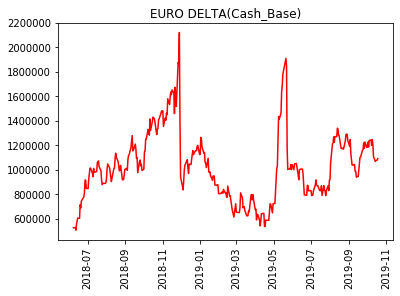

In [18]:
plt.plot(-my_price['Cash_DeltaY'], color = 'red')
plt.xticks(rotation='vertical')
plt.title('EURO DELTA(Cash_Base)')
plt.show()

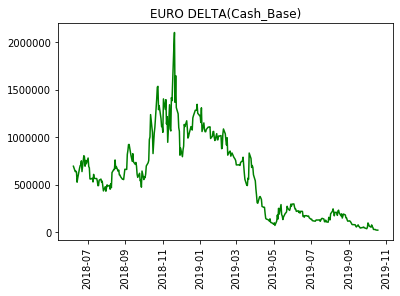

In [19]:
plt.plot(-my_price['Cash_DeltaX'], color = 'green')
plt.xticks(rotation='vertical')
plt.title('EURO DELTA(Cash_Base)')
plt.show()

In [20]:
Korean_Value_my_hedge_Asset = pd.DataFrame( index = my_hedge_Asset.index, columns= my_hedge_Asset.columns)

In [21]:
Korean_Value_my_hedge_Asset['number_of_Futures_X'] = my_hedge_Asset['number_of_Futures_X']/contract_Value_X
Korean_Value_my_hedge_Asset['number_of_Futures_Y'] = my_hedge_Asset['number_of_Futures_Y']/contract_Value_Y
Korean_Value_my_hedge_Asset['number_of_Put_X'] = my_hedge_Asset['number_of_Put_X']/contract_Value_X
Korean_Value_my_hedge_Asset['number_of_Put_Y'] = my_hedge_Asset['number_of_Put_Y']/contract_Value_Y
Korean_Value_my_hedge_Asset['Profit'] = my_hedge_Asset['Profit']
Korean_Value_my_hedge_Asset['ELS_Value'] = my_hedge_Asset['ELS_Value']
Korean_Value_my_hedge_Asset['Put_Value_X'] = (my_hedge_Asset['Put_Value_X'] * EURO_Currency['EURO']).astype(np.int64)
Korean_Value_my_hedge_Asset['Put_Value_Y'] = (my_hedge_Asset['Put_Value_Y'] * HKD_Currency['HKD']).astype(np.int64)
Korean_Value_my_hedge_Asset['XValue'] = (my_hedge_Asset['XValue'] * EURO_Currency['EURO']).astype(np.int64)
Korean_Value_my_hedge_Asset['YValue'] = (my_hedge_Asset['YValue'] * HKD_Currency['HKD']).astype(np.int64)
Korean_Value_my_hedge_Asset['dDeltaX_adj'] = my_hedge_Asset['dDeltaX_adj']/contract_Value_X
Korean_Value_my_hedge_Asset['dDeltaY_adj'] = my_hedge_Asset['dDeltaY_adj']/contract_Value_Y
Korean_Value_my_hedge_Asset['Economic_Profit'] = my_hedge_Asset['Economic_Profit']


In [22]:
Korean_Value_my_hedge_Asset_hedge_Asset

,number_of_Futures_X,number_of_Put_X,number_of_Futures_Y,number_of_Put_Y,Profit,Put_Value_X,Put_Value_Y,ELS_Value,XValue,YValue,dDeltaX_adj,dDeltaY_adj,Economic_Profit
Symbol Name,,,,,,,,,,,,,
2018-06-08,-5.6,-185.8,6.96,-213.32,4707518306,-985712411,-3571805894,-14850003968,-233233706,578064285,5.6,-6.96,149999999
2018-06-11,-6.6,-175.0,7.86,-210.88,4625847212,-897948989,-3519960341,-14876631040,-279447454,654610133,1.0,-0.90,207937881
2018-06-12,-6.2,-174.7,6.26,-206.34,4505026304,-902848599,-3431830843,-14937497600,-262333084,522277271,-0.4,1.60,170346860
2018-06-13,-6.4,-172.9,10.74,-213.44,4625247607,-886698751,-3643273088,-14838067200,-270801000,887342365,0.2,-4.48,95275767
2018-06-14,-9.1,-154.1,15.26,-211.94,4512445320,-747065136,-3678058559,-14821917696,-389997287,1255008280,2.7,-4.52,87321624
2018-06-15,-7.6,-159.9,18.06,-213.90,4575703034,-800501542,-3813318940,-14755360768,-326155678,1498563292,-1.5,-2.80,-38117449
2018-06-18,-4.9,-176.6,16.74,-216.44,4707381093,-926647725,-3875793349,-14728738816,-208590914,1395978422,-2.7,1.32,-95059980
2018-06-19,-3.8,-179.5,27.26,-230.58,4952321397,-978063015,-4421889137,-14461072384,-160980752,2221817713,-1.1,-10.52,-447630755
2018-06-20,-3.7,-180.9,24.30,-229.24,4877428474,-977190222,-4349381992,-14536721408,-156639648,1966975164,-0.1,2.96,-449143739


In [217]:
writer = pd.ExcelWriter('ELS헤징.xlsx')
Korean_Value_my_hedge_Asset.to_excel(writer, 'Sheet1')
writer.save()